This is the Group 9 Project Report ipynb File!

The following cell loads the packages that we will be using for this project

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(infer)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

This cell will import our data from a link. The link is a public GitHub created by Ryan as the link directly from the source was a .zip file. The GitHub allows us to get around this problem

In [2]:
url <- "https://raw.githubusercontent.com/EPICxFLIPPER/data/main/OnlineNewsPopularity.csv"
popularity <- read_csv(url) 

head(popularity)

Rows: 39644 Columns: 61
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): url
dbl (60): timedelta, n_tokens_title, n_tokens_content, n_unique_tokens, n_no...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,0.10000000,0.7,-0.3500000,-0.600,-0.2000000,0.5000000,-0.1875000,0.00000000,0.1875000,593
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,⋯,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0.0000000,0.0000000,0.50000000,0.0000000,711
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,⋯,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0.0000000,0.0000000,0.50000000,0.0000000,1500
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731,9,531,0.5037879,1,0.6656347,9,0,1,⋯,0.13636364,0.8,-0.3696970,-0.600,-0.1666667,0.0000000,0.0000000,0.50000000,0.0000000,1200
http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.4156456,1,0.5408895,19,19,20,⋯,0.03333333,1.0,-0.2201923,-0.500,-0.0500000,0.4545455,0.1363636,0.04545455,0.1363636,505
http://mashable.com/2013/01/07/beewi-smart-toys/,731,10,370,0.5598886,1,0.6981982,2,2,0,⋯,0.13636364,0.6,-0.1950000,-0.400,-0.1000000,0.6428571,0.2142857,0.14285714,0.2142857,855


The next cell wrangles our data. This data was already quite tidy, only a few null values had to be removed. We also selected our predictors as seen in glimpse, and the column being predicted, shares. We selected these predictors as they would be easily manipulated by a human and are thus or interest to us. Through our exploritory analysis, there were quite a few outlier points, both that had high shares, and high word counts. We have also removed a significant number of these points below.

In [3]:
set.seed(9)
#Wrangling
popularity_tidy <- popularity |> 
#removing columns that are specifically not litsted as predictors as well as columns that self reference articles.
select(-url, -timedelta) |>
# select(n_tokens_title:average_token_length, shares) |>
select(n_tokens_title:shares, -num_videos, -n_non_stop_words , -n_non_stop_unique_tokens,
      -data_channel_is_lifestyle:-is_weekend,-LDA_00:-LDA_04, - num_self_hrefs, -num_keywords:-global_rate_negative_words,
      -avg_positive_polarity: -abs_title_sentiment_polarity, -n_unique_tokens) |>
filter(shares < 5000)|>
arrange(desc(shares)) |>
drop_na(n_tokens_content:shares) |>
#Removing valeus where 0 doesnt make sense
filter(n_tokens_title >0) |>
filter(n_tokens_content>0) |>
filter(average_token_length>0) |>
filter(shares>0)



glimpse(popularity_tidy)

Rows: 33,516
Columns: 8
$ n_tokens_title       <dbl> 11, 8, 10, 12, 6, 9, 13, 10, 10, 9, 7, 7, 7, 9, 9…
$ n_tokens_content     <dbl> 214, 701, 488, 277, 560, 381, 612, 1085, 190, 663…
$ num_hrefs            <dbl> 2, 8, 3, 7, 13, 4, 30, 22, 7, 10, 35, 1, 7, 9, 5,…
$ num_imgs             <dbl> 0, 12, 11, 1, 1, 0, 23, 11, 0, 1, 1, 0, 16, 1, 1,…
$ average_token_length <dbl> 4.654206, 4.693295, 4.737705, 4.743682, 4.867857,…
$ rate_positive_words  <dbl> 0.6666667, 0.8367347, 0.6551724, 0.7857143, 0.714…
$ rate_negative_words  <dbl> 0.33333333, 0.16326531, 0.34482759, 0.21428571, 0…
$ shares               <dbl> 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900, 4…


In the following line we will take a sample from our data to explore. This is because with such a large data set the R kerenl would crash. A random sample of sufficient size should be representative of the population enough to allow for continued exploration of the data.

In [4]:
set.seed(9)
popularity_sample <- rep_sample_n(popularity_tidy, 5000)

In the next cell we split the data into training and testing data. 80% in the training set and stratzised by shares.

In [5]:
set.seed(9)
#Splitting the data into training and testing data
#Strata = the day the article was published
popularity_split<- initial_split(popularity_sample, prop = .80, strata = shares)
popularity_train<- training(popularity_split)
popularity_test <- testing(popularity_split)


The next two cells explore the means of each of our predictors, as well as a few of the plots below. Since we have a lagre amount of predictors, we only explored a few plots.

In [6]:
set.seed(9)
initial_table <- popularity_train |>
map_df(mean,na.rm =TRUE)
initial_table


replicate,n_tokens_title,n_tokens_content,num_hrefs,num_imgs,average_token_length,rate_positive_words,rate_negative_words,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10.37519,564.2564,10.65558,4.045523,4.687101,0.6998818,0.3001182,1602.385


Warning message:
“Removed 2 rows containing missing values (geom_bar).”


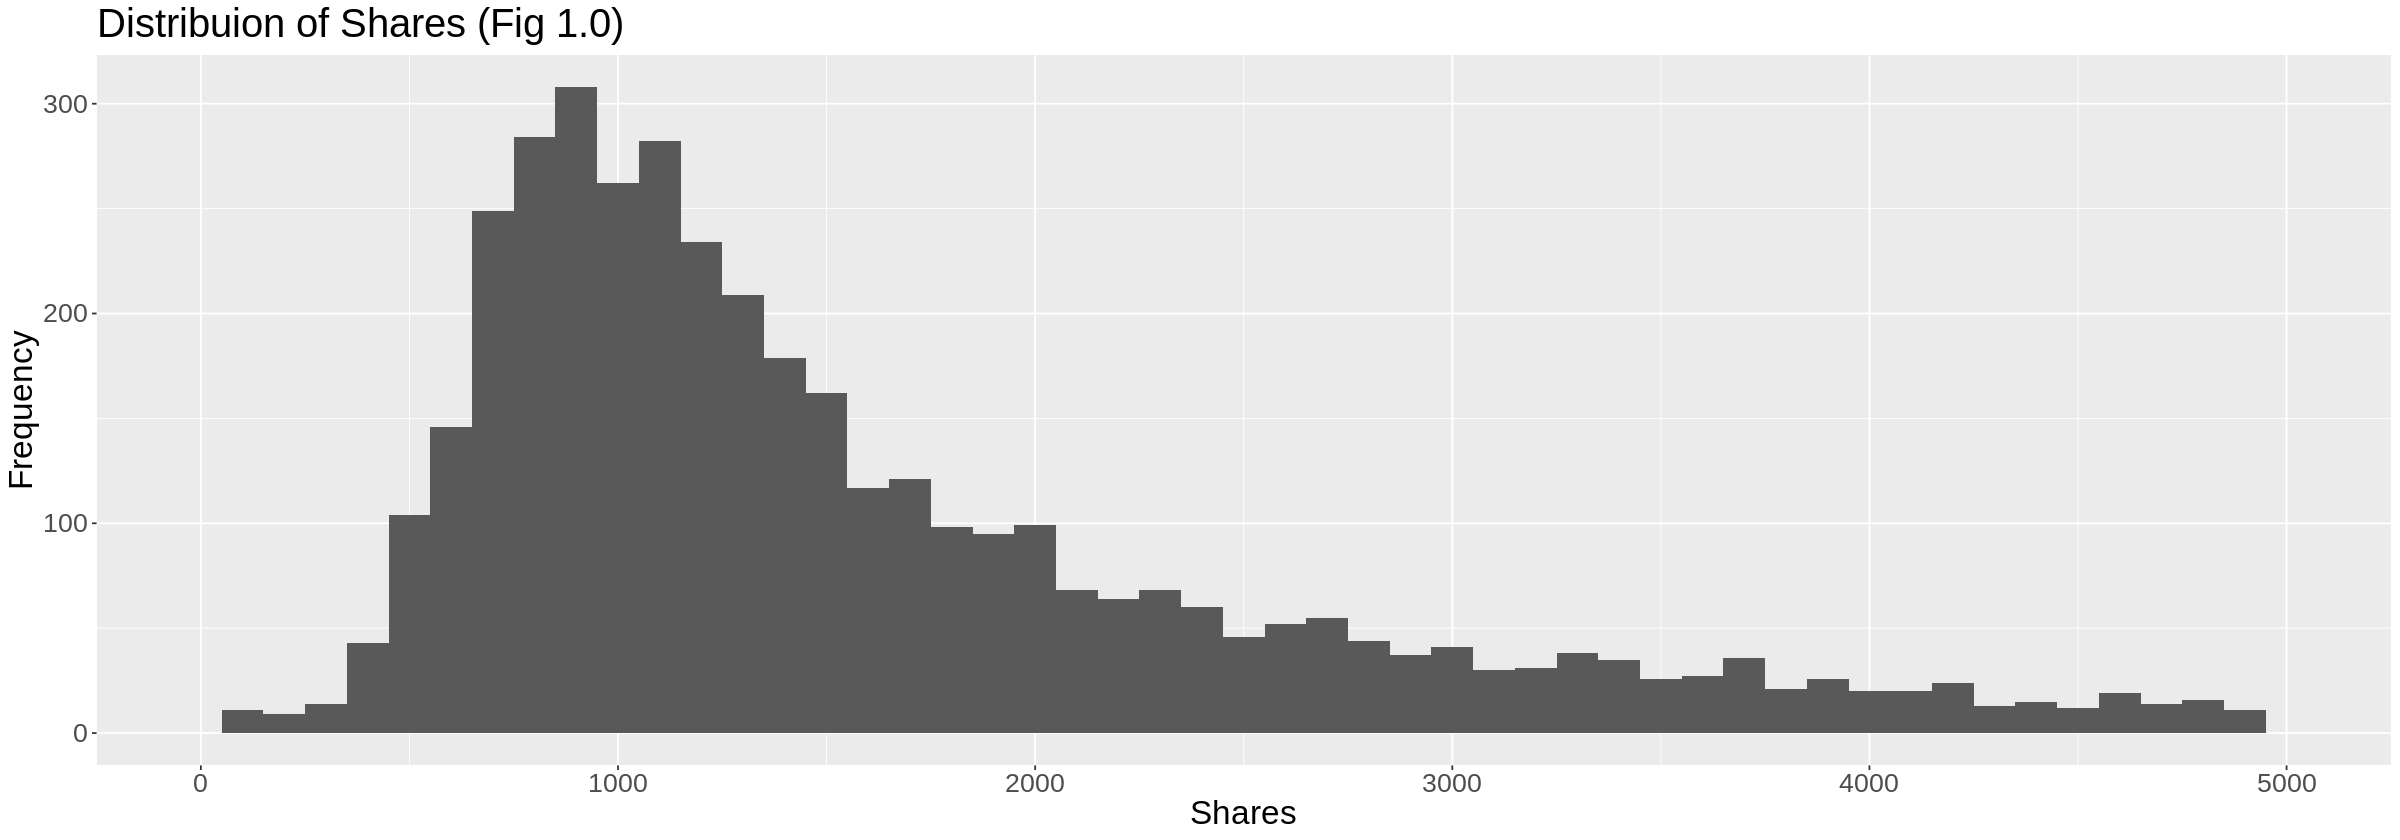

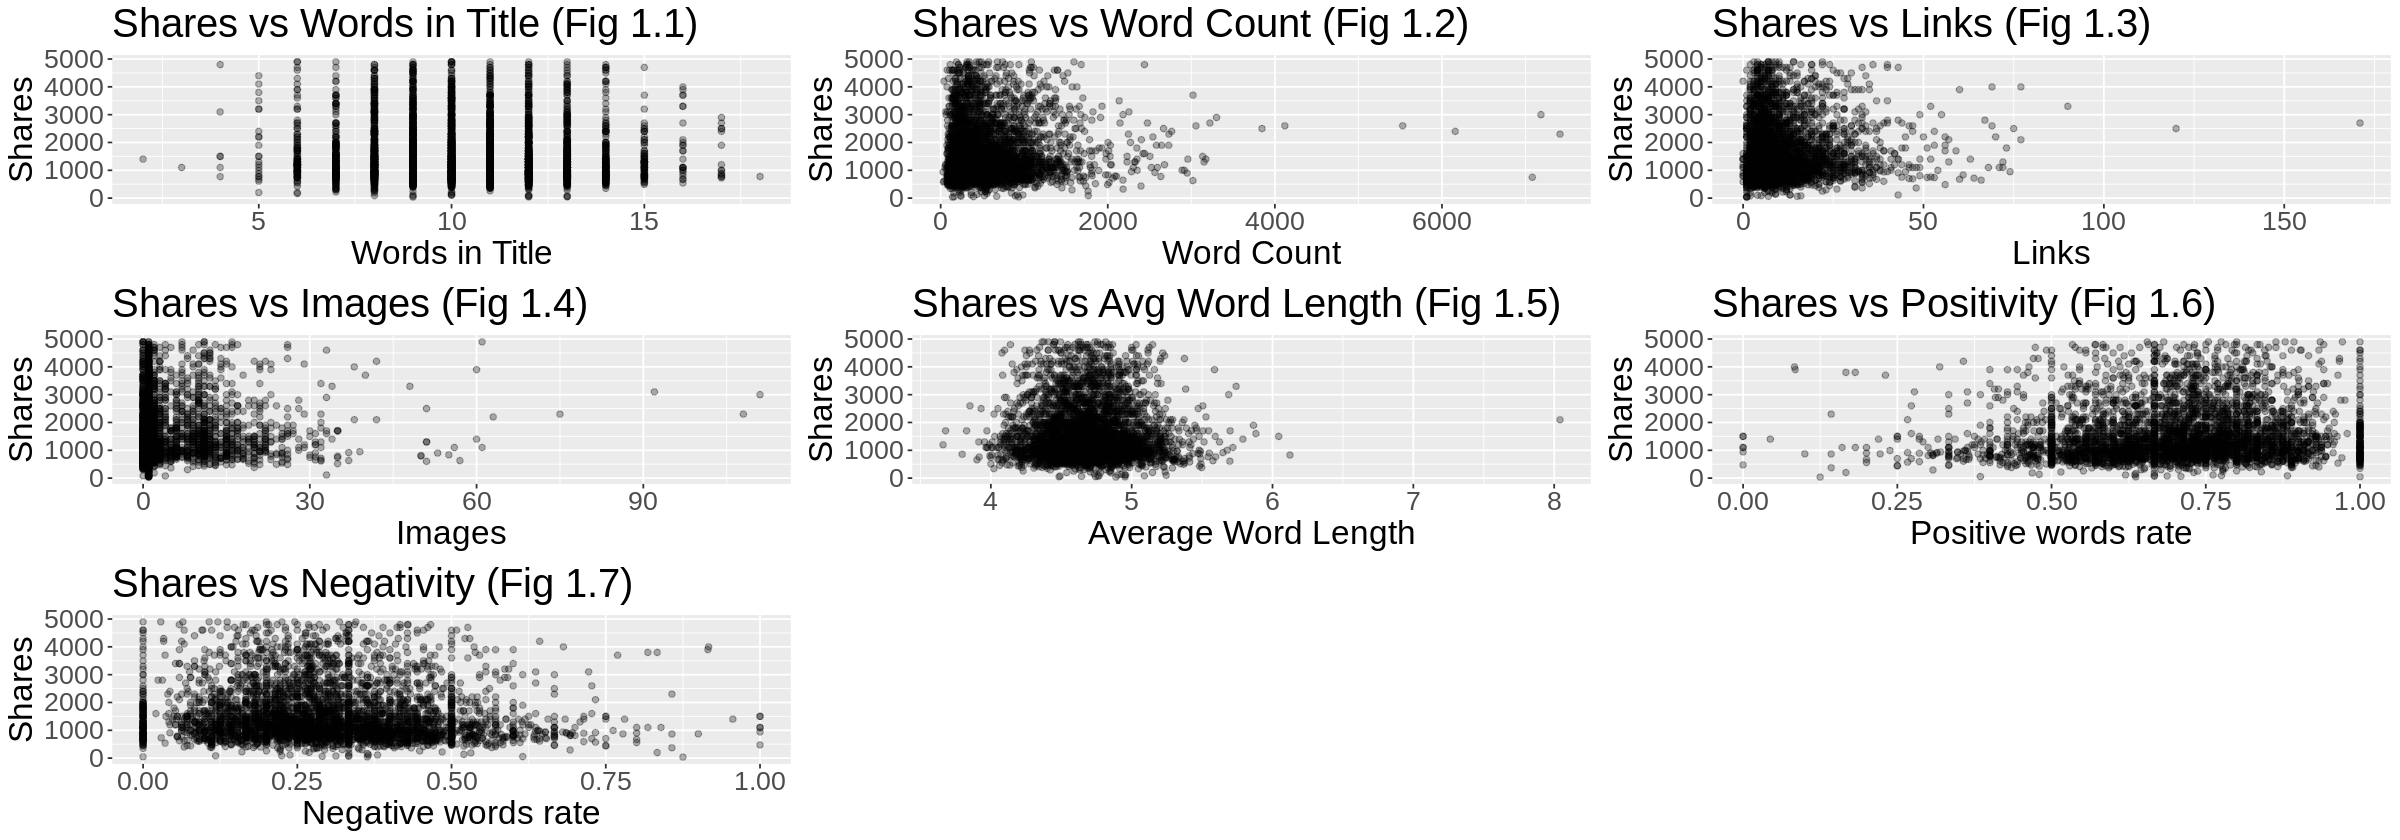

In [7]:
set.seed(9)
#Below are the distributions of the 3 most varable categoreis in our data set. Though some of the categories are less variable, we belive 
#they will still be good predictors of shares.

options(repr.plot.width = 20, repr.plot.height =7)

shares_plot <- popularity_train |> 
ggplot(aes(x = shares)) + geom_histogram(binwidth = 100)+xlim(0,5000) +labs(x = "Shares" , y = "Frequency") +
ggtitle("Distribuion of Shares (Fig 1.0)") + theme(text = element_text(size = 20))


shares_vs_imgs_plot <- popularity_train |>
ggplot(aes(x = num_imgs , y = shares)) + geom_point(alpha = .3) + xlab("Images") + ylab("Shares") +
ggtitle("Shares vs Images (Fig 1.4)") +
theme(text = element_text(size = 20))

shares_vs_word_count_plot <- popularity_train |>
ggplot(aes(x = n_tokens_content , y = shares)) + geom_point(alpha = .3) + xlab("Word Count") + ylab("Shares") +
ggtitle("Shares vs Word Count (Fig 1.2)") +
theme(text = element_text(size = 20))

shares_vs_token_length_plot <- popularity_train |>
ggplot(aes(x = average_token_length , y = shares)) + geom_point(alpha = .3) + xlab("Average Word Length") + ylab("Shares") +
ggtitle("Shares vs Avg Word Length (Fig 1.5)") +
theme(text = element_text(size = 20))

shares_vs_title_plot <- popularity_train |>
ggplot(aes(x = n_tokens_title , y = shares)) + geom_point(alpha = .3) + xlab("Words in Title") + ylab("Shares") +
ggtitle("Shares vs Words in Title (Fig 1.1)") +
theme(text = element_text(size = 20))

shares_vs_links_plot <- popularity_train |>
ggplot(aes(x = num_hrefs , y = shares)) + geom_point(alpha = .3) + xlab("Links") + ylab("Shares") +
ggtitle("Shares vs Links (Fig 1.3)") +
theme(text = element_text(size = 20))

shares_vs_positive_plot <- popularity_train |>
ggplot(aes(x = rate_positive_words , y = shares)) + geom_point(alpha = .3) + xlab("Positive words rate") + ylab("Shares") +
ggtitle("Shares vs Positivity (Fig 1.6)") +
theme(text = element_text(size = 20))

shares_vs_negative_plot <- popularity_train |>
ggplot(aes(x = rate_negative_words , y = shares)) + geom_point(alpha = .3) + xlab("Negative words rate") + ylab("Shares") +
ggtitle("Shares vs Negativity (Fig 1.7)") +
theme(text = element_text(size = 20))

plots <- plot_grid(
    shares_vs_title_plot,
    shares_vs_word_count_plot,
    shares_vs_links_plot,
    shares_vs_imgs_plot,
    shares_vs_token_length_plot,
    shares_vs_positive_plot,
    shares_vs_negative_plot,
ncol = 3) 
shares_plot
plots

The following cell is for cross validation. Since we are using a knn regression model, we need to find the best number of neighobrs to predict off of. We will be using a 5 fold cross validation.

In [8]:
#I will be loacting the best neighbors to use
set.seed(9)
popularity_spec <- nearest_neighbor(weight_func = "rectangular" , neighbors = tune()) |> 
set_engine("kknn") |> 
set_mode("regression")

popularity_recipe <- recipe(shares~., data = popularity_train) |> 
step_scale(all_predictors()) |> 
step_center(all_predictors())

gridvals <- tibble(neighbors = seq(from = 40, to = 80, by = 1))
popularity_vfold <- vfold_cv(data = popularity_train, v = 5, strata = shares)

popularity_fit <- workflow() |>
add_recipe(popularity_recipe) |>
add_model(popularity_spec) |>
tune_grid(resamples = popularity_vfold, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "rmse") |>
arrange(mean) |>
select(neighbors) |>
slice(1) |>
pull()



popularity_fit
                   


! Fold1: preprocessor 1/1: Column(s) have zero variance so scaling cannot be used: `replicate`. Con...

! Fold2: preprocessor 1/1: Column(s) have zero variance so scaling cannot be used: `replicate`. Con...

! Fold3: preprocessor 1/1: Column(s) have zero variance so scaling cannot be used: `replicate`. Con...

! Fold4: preprocessor 1/1: Column(s) have zero variance so scaling cannot be used: `replicate`. Con...

! Fold5: preprocessor 1/1: Column(s) have zero variance so scaling cannot be used: `replicate`. Con...



[1] 79

Next We will train our data with the number of predictors found above as well as compare our predictions to the testing set.

In [9]:
set.seed(9)
popularity_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = popularity_fit) |> 
set_engine("kknn") |> 
set_mode("regression")

popularity_fit_2 <- workflow() |> 
add_recipe(popularity_recipe) |>
add_model(popularity_spec_2) |>
fit(data = popularity_train)

popularity_predictions <- predict(popularity_fit_2, popularity_test) |> 
bind_cols(popularity_test)

head(popularity_predictions)

Warning message:
“Column(s) have zero variance so scaling cannot be used: `replicate`. Consider using `step_zv()` to remove those columns before normalizing”


.pred,replicate,n_tokens_title,n_tokens_content,num_hrefs,num_imgs,average_token_length,rate_positive_words,rate_negative_words,shares
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1926.165,1,8,944,30,19,4.623941,0.5384615,0.4615385,4000
1306.911,1,8,416,9,1,4.612981,0.4687500,0.5312500,2200
1959.228,1,9,1524,4,14,4.677822,0.8913043,0.1086957,1600
1788.278,1,9,642,16,11,4.442368,0.7631579,0.2368421,2100
1724.532,1,9,1009,14,1,4.449950,0.7450980,0.2549020,2200
1619.342,1,10,175,5,0,4.531429,0.7500000,0.2500000,1400


Below we will explore a few of our predictors vs share plots again this time with how the shares were predicted overlayed onto the graph

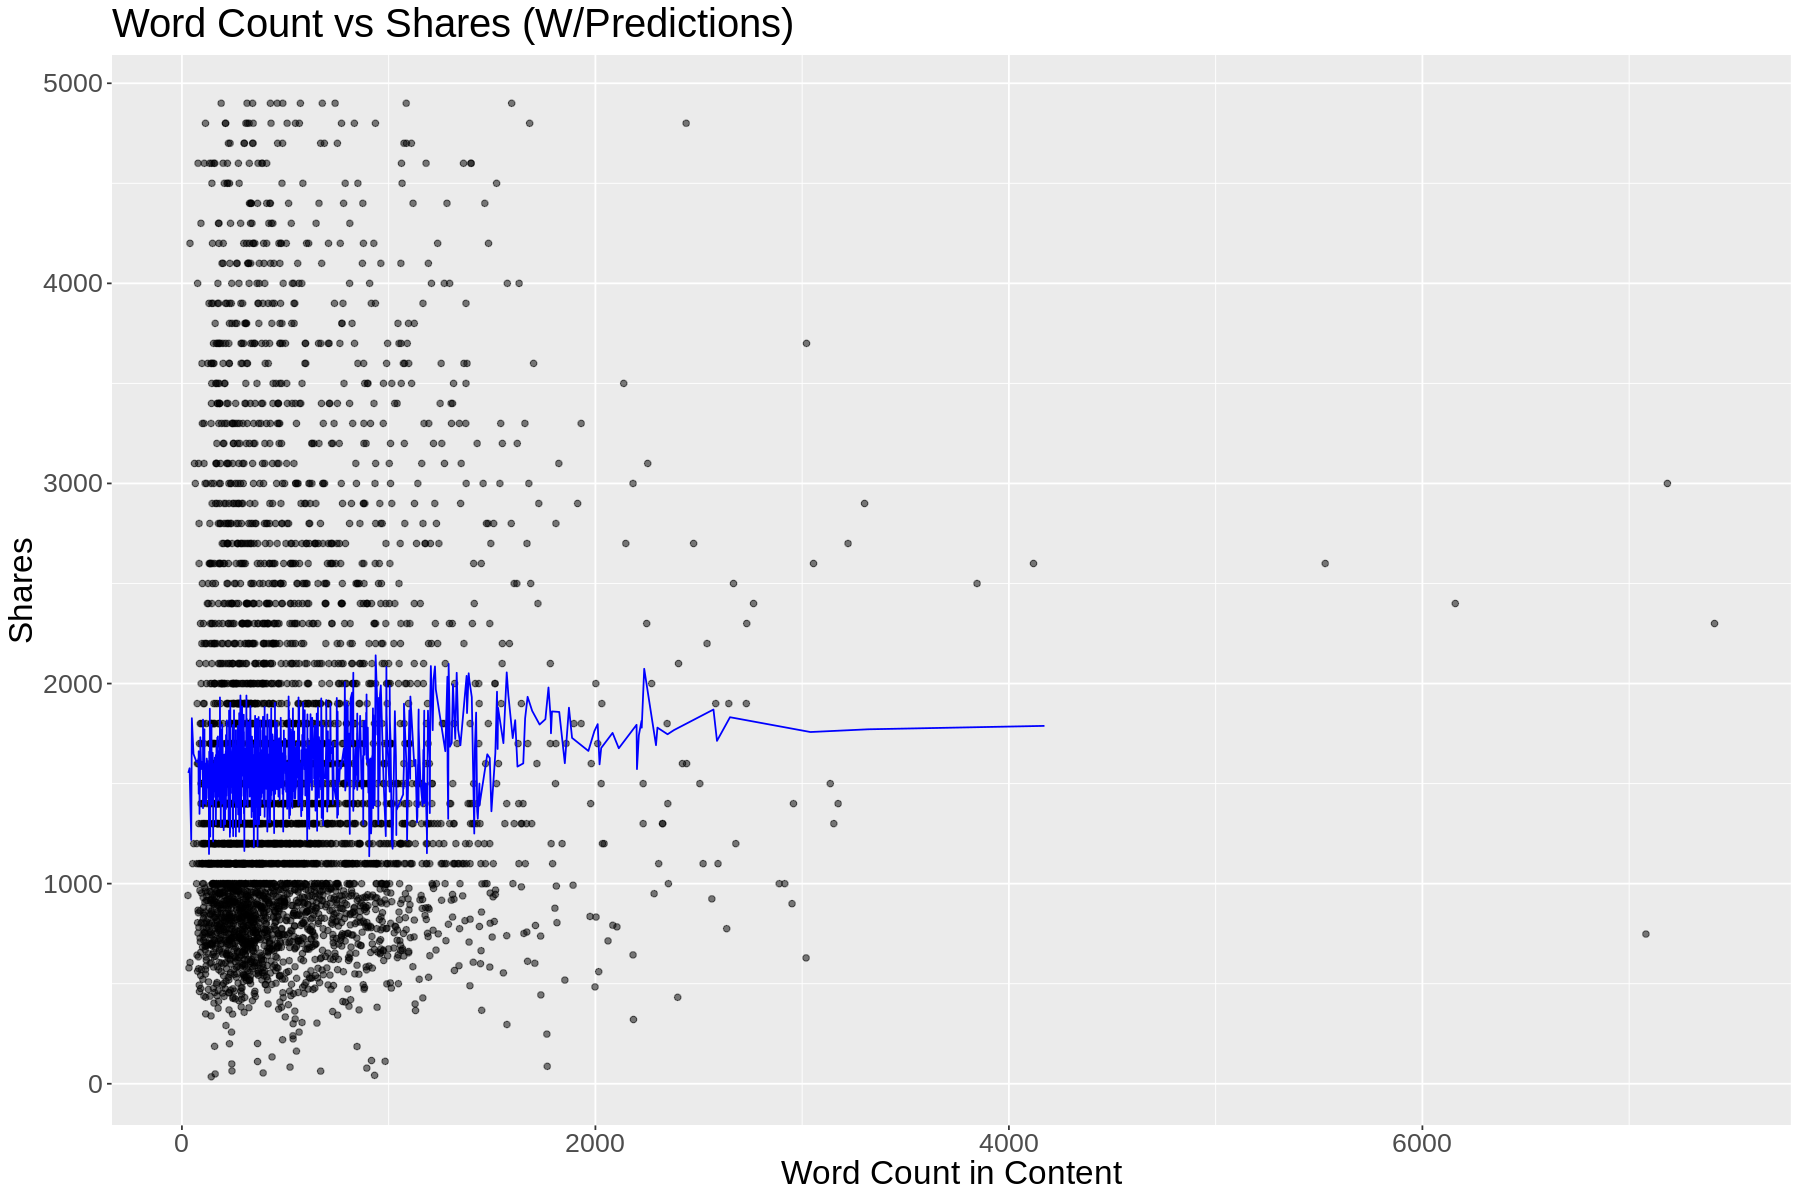

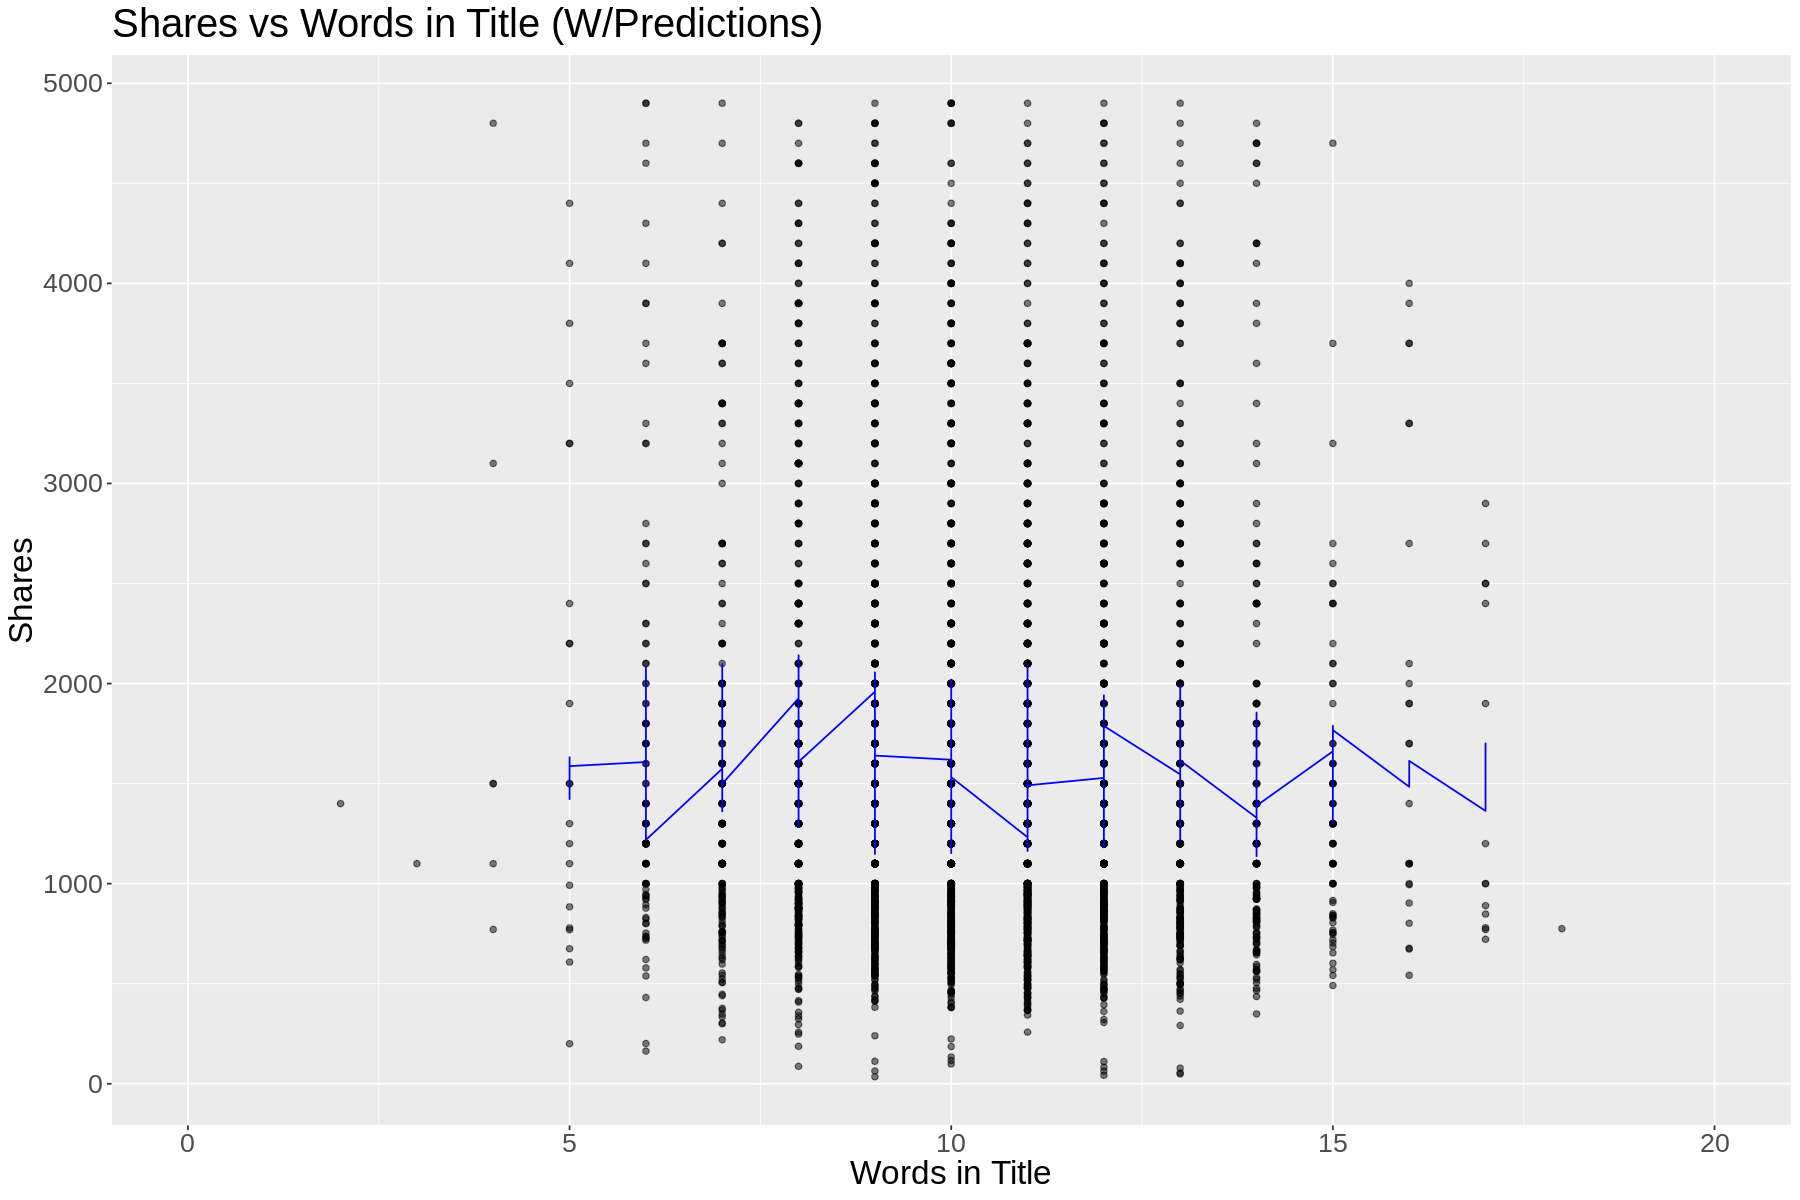

Warning message:
“Removed 161 rows containing missing values (geom_point).”
Warning message:
“Removed 48 row(s) containing missing values (geom_path).”


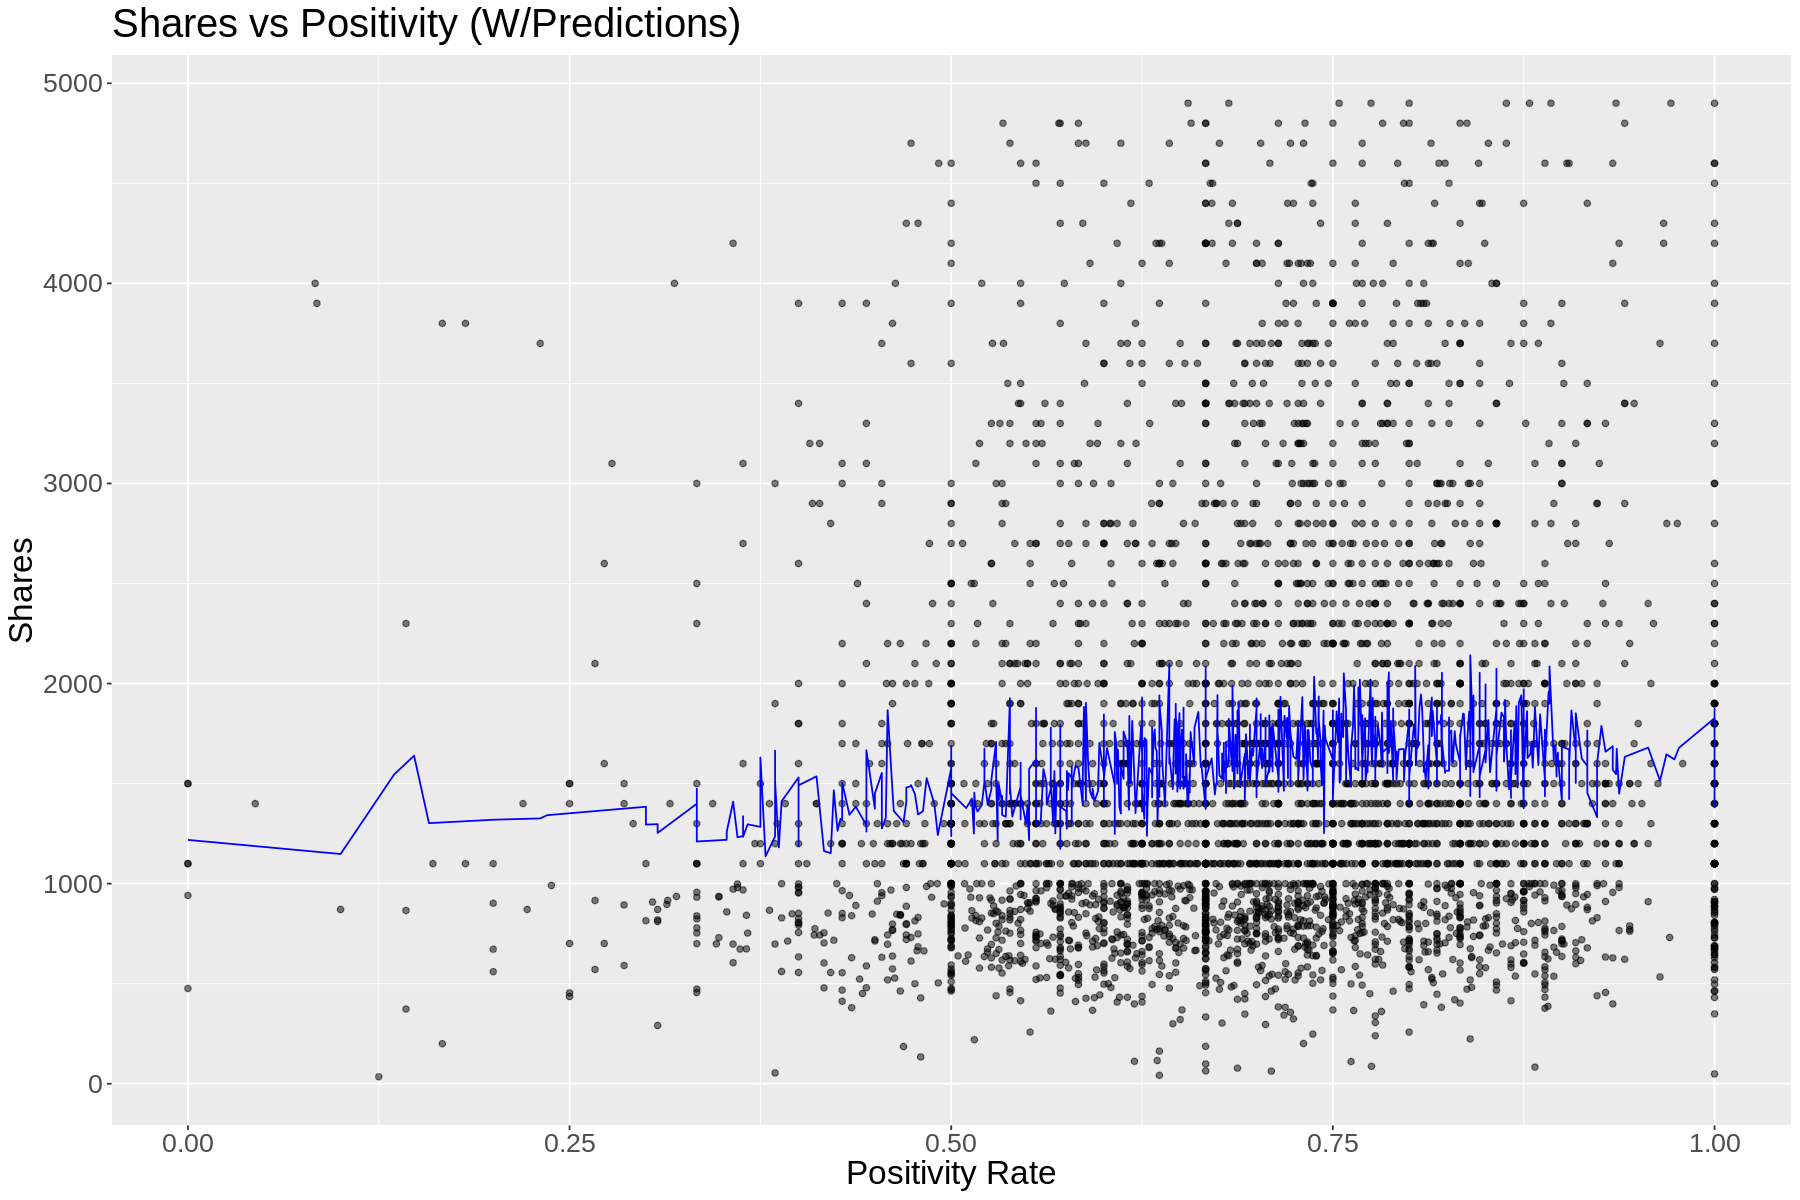

Warning message:
“Removed 484 rows containing missing values (geom_point).”
Warning message:
“Removed 115 row(s) containing missing values (geom_path).”


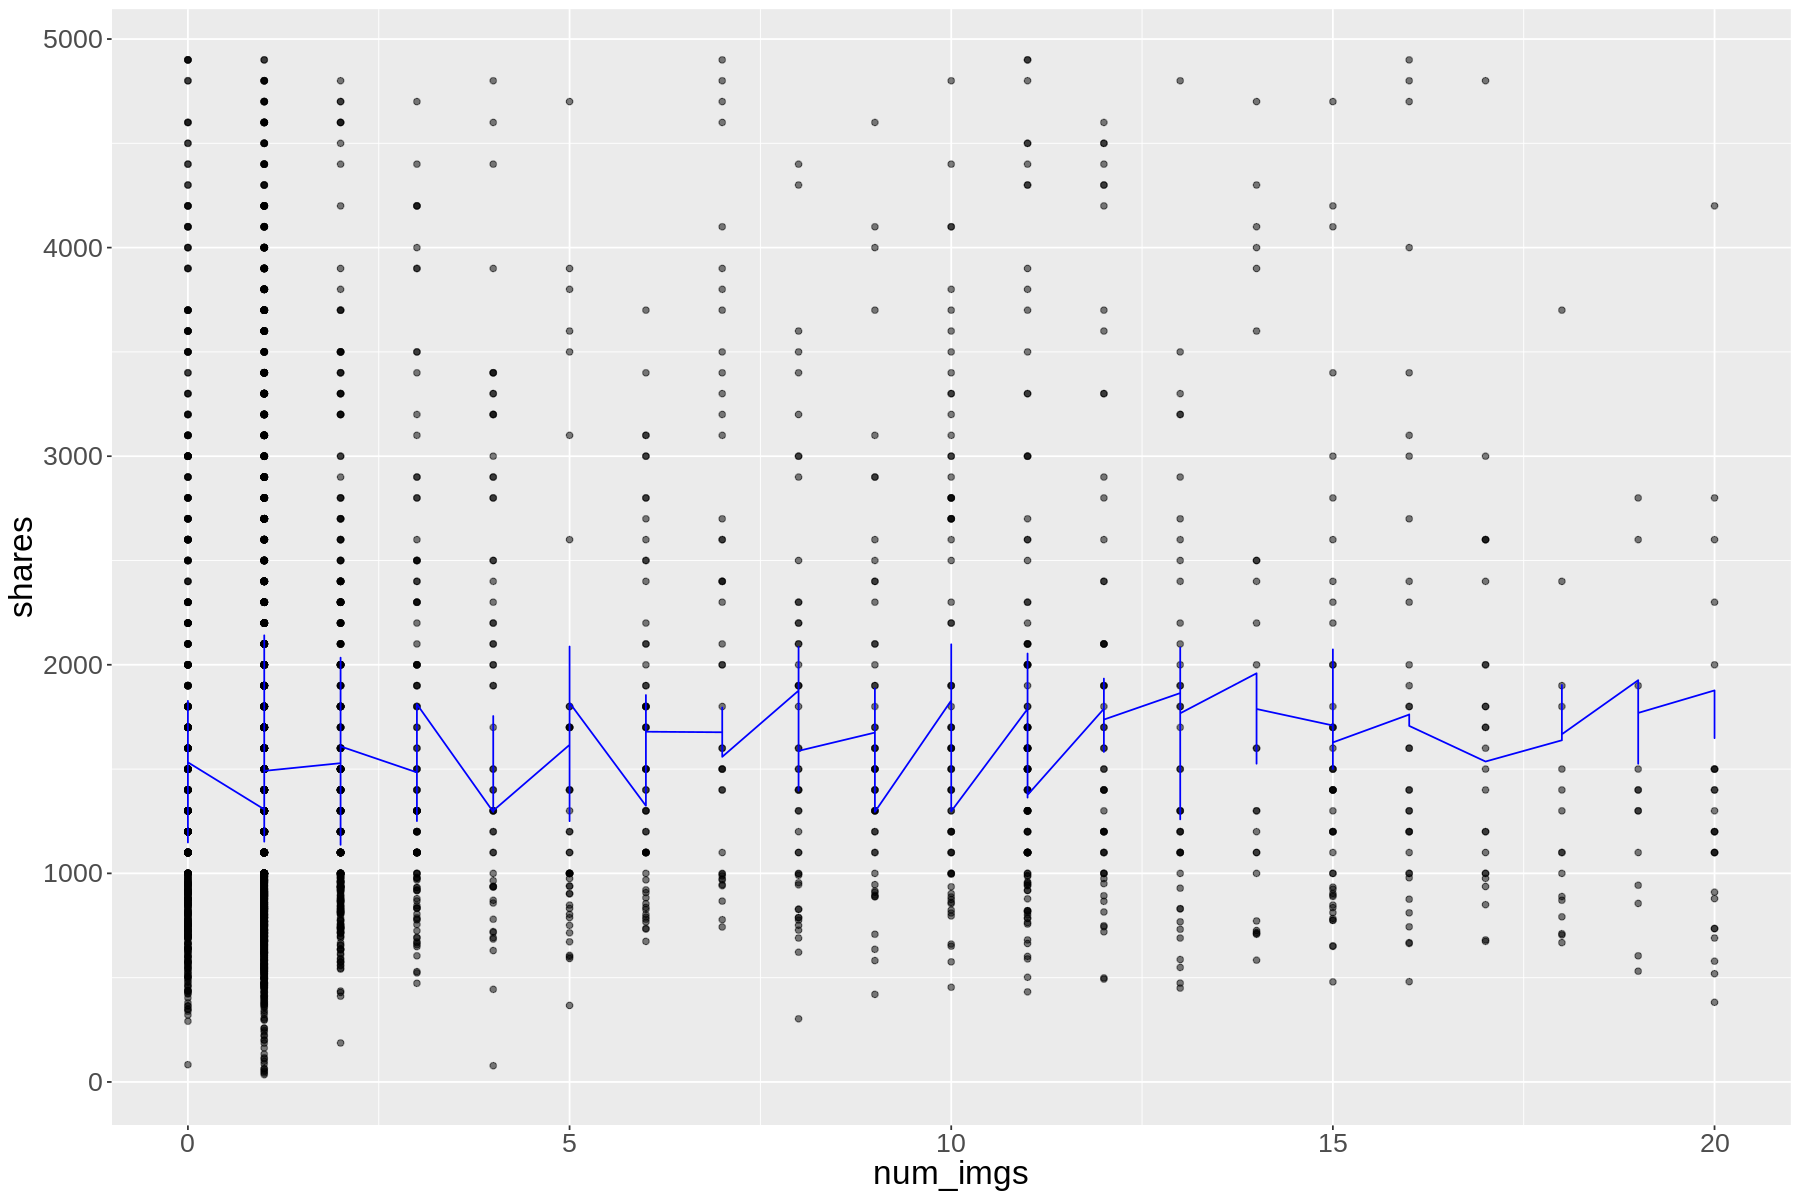

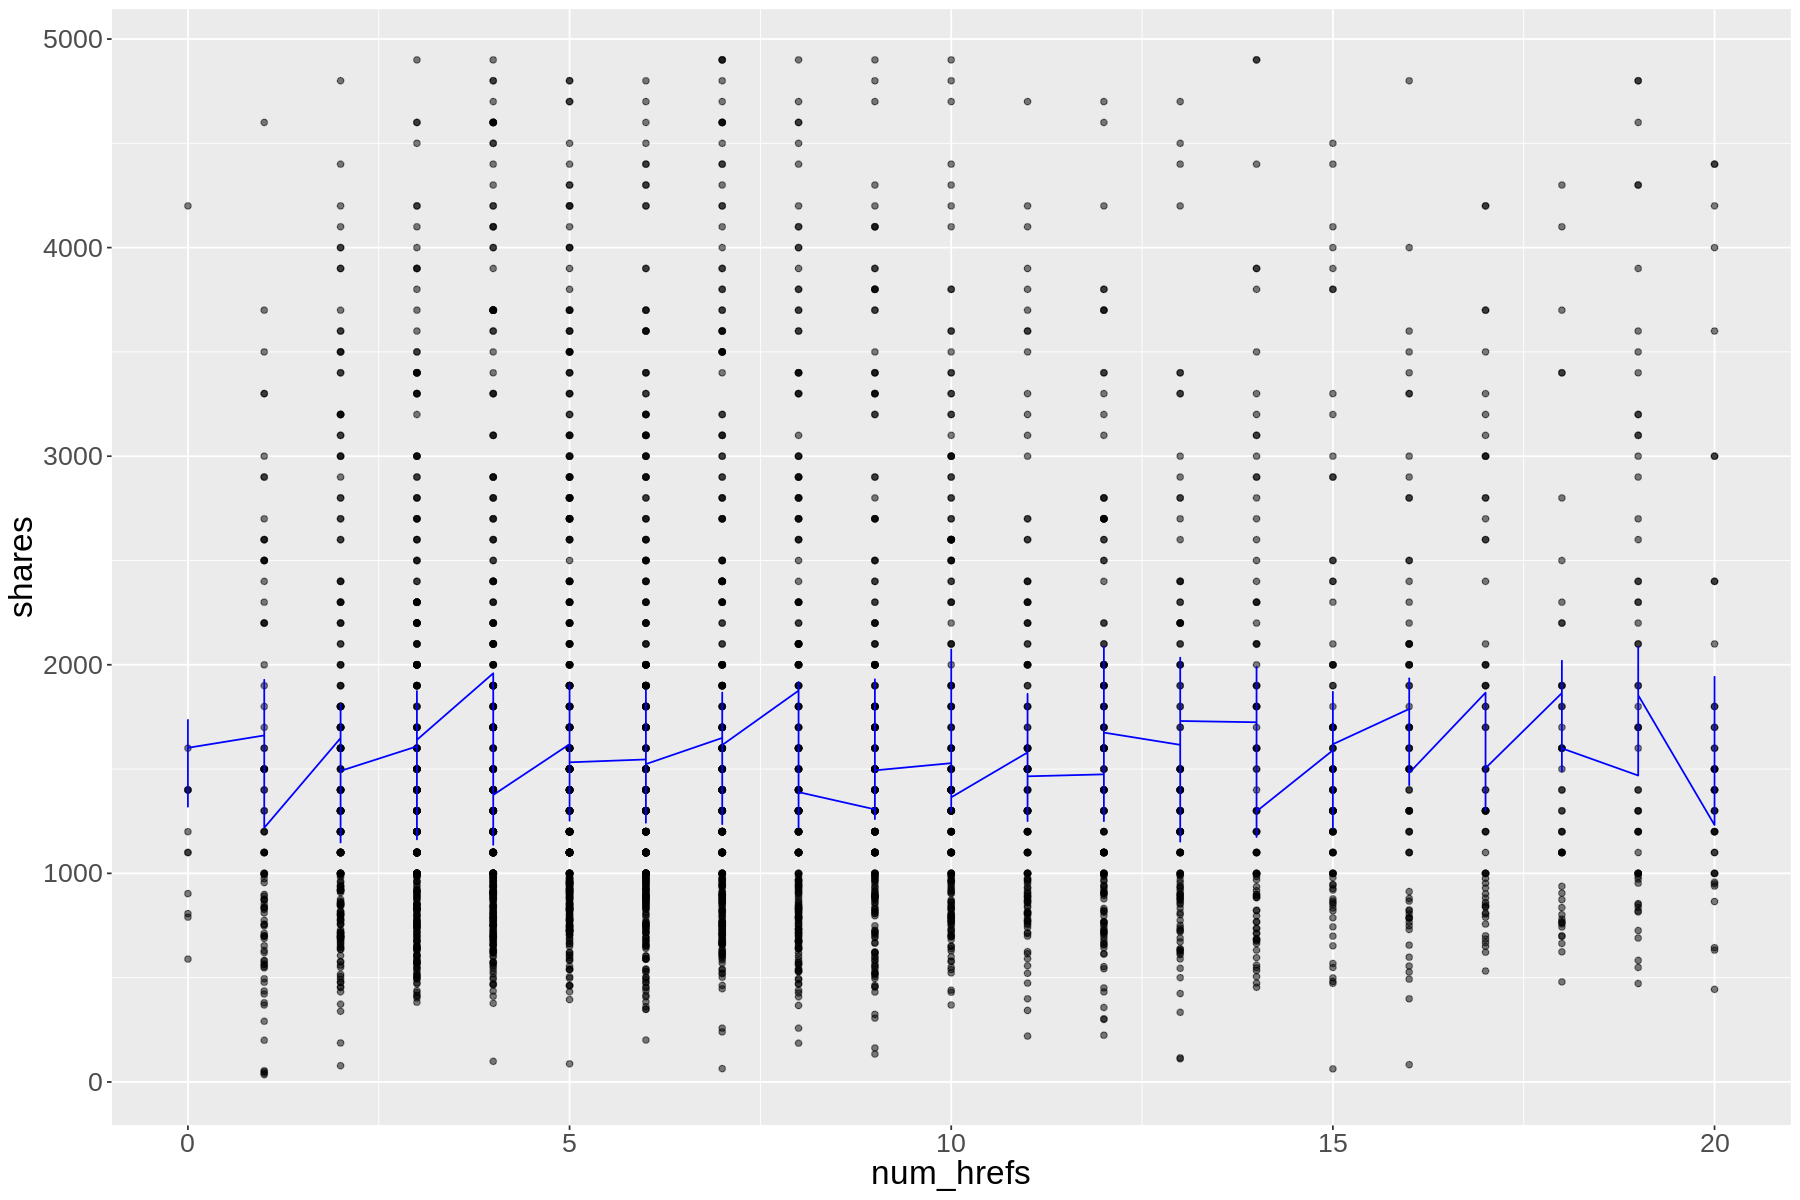

In [14]:
set.seed(9)
options(repr.plot.width = 15 , repr.plot.height =10)
predictions_plot <- popularity_train |> 
ggplot(aes(x = n_tokens_content , y = shares )) + geom_point(alpha = .5) +
geom_line(data = popularity_predictions , aes(x = n_tokens_content , y = .pred), color = "blue") +
labs(x = "Word Count in Content" , y = "Shares", color = "Predictions")+
ggtitle("Word Count vs Shares (W/Predictions)") + theme(text = element_text(size = 20))
predictions_plot

plot_2 <- popularity_train |> 
ggplot(aes(x = n_tokens_title , y = shares )) + geom_point(alpha = .5) +
geom_line(data = popularity_predictions , aes(x = n_tokens_title , y = .pred), color = "blue") + xlim(0,20) +
theme(text = element_text(size = 20)) + labs(x = "Words in Title" , y = "Shares", color = "Predictions") +
ggtitle("Shares vs Words in Title (W/Predictions)")
plot_2

plot_3 <- popularity_train |> 
ggplot(aes(x = rate_positive_words , y = shares )) + geom_point(alpha = .5) +
geom_line(data = popularity_predictions , aes(x = rate_positive_words , y = .pred), color = "blue") + xlim(0,1) +
theme(text = element_text(size = 20)) + labs(x = "Positivity Rate" , y = "Shares" , color = "Predictions")+
ggtitle("Shares vs Positivity (W/Predictions)")
plot_3


plot_5 <- popularity_train |> 
ggplot(aes(x = num_imgs , y = shares )) + geom_point(alpha = .5) +
geom_line(data = popularity_predictions , aes(x = num_imgs , y = .pred), color = "blue") + xlim(0,20) +
theme(text = element_text(size = 20))
plot_5

plot_6 <- popularity_train |> 
ggplot(aes(x = num_hrefs , y = shares )) + geom_point(alpha = .5) +
geom_line(data = popularity_predictions , aes(x = num_hrefs , y = .pred), color = "blue") + xlim(0,20) +
theme(text = element_text(size = 20))
plot_6